In [ ]:
library(dplyr)
library(ggplot2)
library(ggrepel)
library(patchwork)
library(grid)
library(pheatmap)
library(RColorBrewer)
library(forcats)
suppressPackageStartupMessages(library(GenomicRanges))

source("/projects/ps-renlab2/y2xie/scripts/Paired-HiC/phc_help.R")
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

## Compartment comparasion (Fig.1E)

In [ ]:
### Read compartment
comp <- list()
for (f in list.files("../04.matrices/mFC_240101_DPT_rna_annotate//compartment/", pattern = ".*_raw_comp.bedGraph")){
    cluster = sub("_raw_comp.bedGraph", "", f)
    tmp = read.table(paste0("../04.matrices/mFC_240101_DPT_rna_annotate/compartment/", f), sep = "\t", skip = 1)
    tmp <- tmp %>% setNames(c("chrom", "start", "end", cluster))
    comp[[f]] <- tmp[, 4, drop = F]
}

comp <- do.call(cbind, comp) 
comp[,c("chrom", "start", "end")] <- tmp[, c("chrom", "start", "end")]


### Select bin with most variable genes!
suppressPackageStartupMessages(library(GenomicRanges))
library(Seurat)

obj <- readRDS("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/seurat_object/FC_RNA_Seurat_merged_rmScrublet_221229.rds")
mm10 <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/mm10/mm10.gcode.vm25.bed")
mm10_genes.gr = GRanges(mm10[, 1], IRanges::IRanges(mm10[, 2], mm10[, 3]), gene = mm10[,5])
qry <- mm10 %>% filter(V5 %in% VariableFeatures(obj))
qry.gr <- GRanges(qry[, 1], IRanges::IRanges(qry[, 2], qry[, 3]), gene = qry[,5])

qry.bin <- qry.gr %>%
as.data.frame %>%
mutate(startb = floor(start / 100000), endb = ceiling(end / 100000)) %>%
dplyr::select(c(seqnames, startb, endb)) %>%
distinct

### coarse into 100kb bin
split_rows <- function(c, a, b) {
  if (b - a > 1) {
    num_rows <- b - a
    new_rows <- data.frame(seqnames = rep(c, times = num_rows), startb = a:(b-1), endb = (a+1):b)
    return(new_rows)
  } else {
    return(data.frame(seqnames = c, startb = a, endb = b))
  }
}

result <- qry.bin %>%
rowwise() %>%
do(split_rows(.$seqnames, .$startb, .$endb)) %>%
ungroup()

valid_bin <- result %>% 
distinct %>%
mutate(start = 100000*startb, end = 100000*endb) %>%
mutate(bin = paste0(seqnames, "-", as.integer(start), "-", as.integer(end))) %>%
dplyr::select(bin) %>% unlist

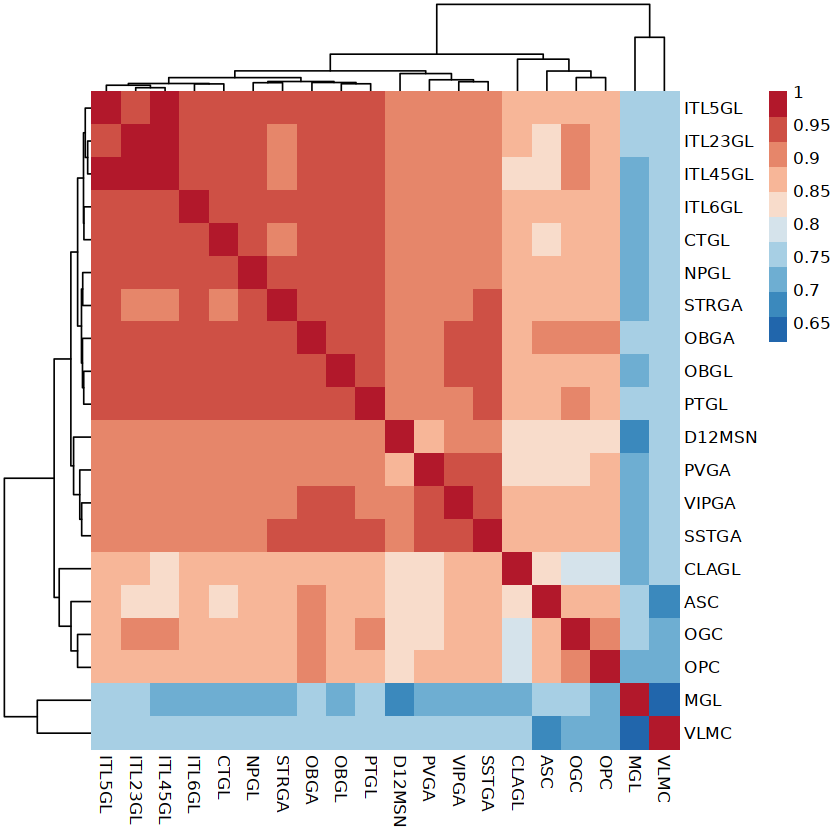

In [270]:
all_bin <- paste0(tmp$chrom, "-", tmp$start, "-", tmp$end)
valid_id <- which(all_bin %in% valid_bin)
t1 <- cor(comp[valid_id, all_order], method = "spearman") %>%
pheatmap(display_numbers = F, number_color = "white", border_color = NA,
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(10))

## Differential compartment (Fig.2A-B)

In [98]:
corder <- c("ASC", "OGC", "OPC", "MGL", 
            "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "CTGL", "NPGL", "OBGL",
            "D12MSN", "PVGA", "VIPGA", "SSTGA", "STRGA", "OBGA")

comp <- read.csv('../04.matrices/mFC_240101_DPT_rna_annotate/compartment/dchic/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header = T)
binall <- comp[,c('chr', 'start', 'end', 'sample_maha', 'pval', 'padj')]
binall$bin <- paste0(binall$chr, "-", (binall$start + 1), "-", binall$end)

rownames(comp) <- binall$bin
comp <- comp[, corder]

dim(comp)
idx <- which(scale(binall[,'sample_maha']) > abs(stats::qnorm(0.025)) & binall$padj < 0.01)
length(idx)

[1] 21791    17

[1] 895

### Compare with histone modifications

In [99]:
k27ac <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27ac_100kb_CPM_by_class.csv", row.names = 1)
k27me3 <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27me3_100kb_CPM_by_class.csv", row.names = 1)

ck27ac <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27ac_100kb_CPM_by_cluster.csv", row.names = 1)
ck27me3 <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27me3_100kb_CPM_by_cluster.csv", row.names = 1)
k27ac <- cbind(k27ac, ck27ac)
k27me3 <- cbind(k27me3, ck27me3)

colnames(k27ac)

[1] "NonN"      "GABA"      "Glutamate" "OPC"       "OGC"       "ASC"      
 [7] "SSTGA"     "ITL23GL"   "VIPGA"     "ITL45GL"   "D12MSN"    "STRGA"    
[13] "CTGL"      "NPGL"      "ITL5GL"    "OBGA"      "OBGL"      "ITL6GL"   
[19] "PTGL"      "MGL"       "PVGA"      "CLAGL"     "VLMC"

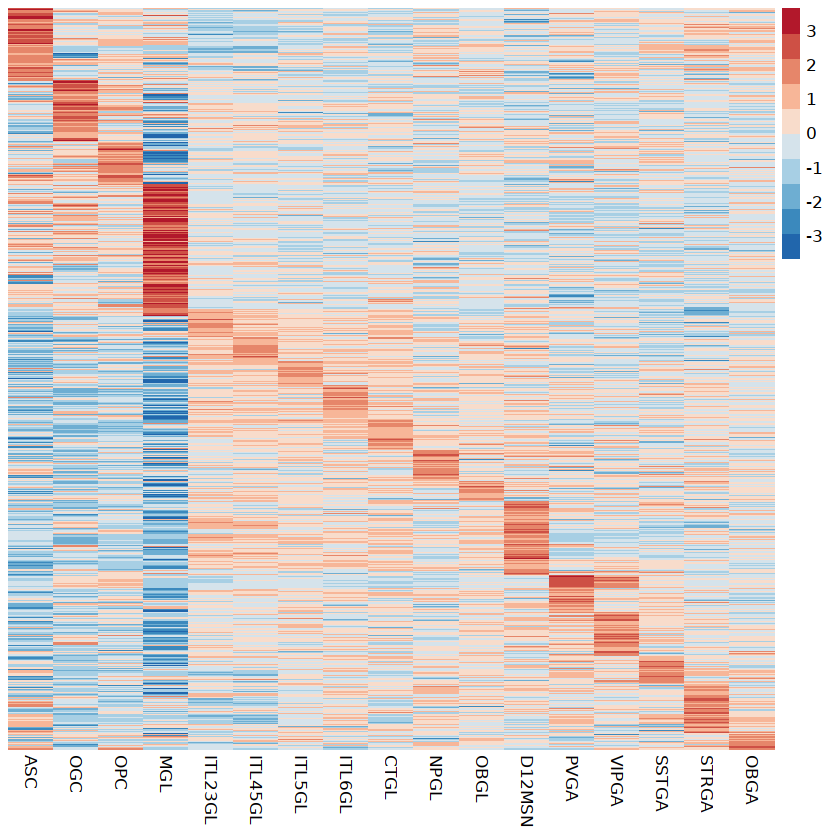

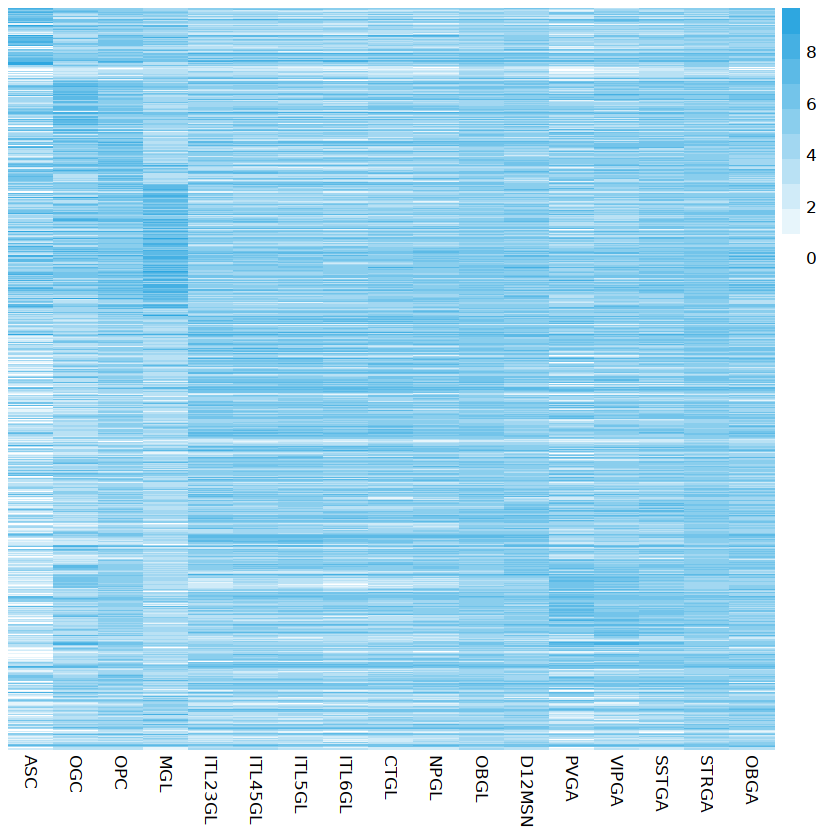

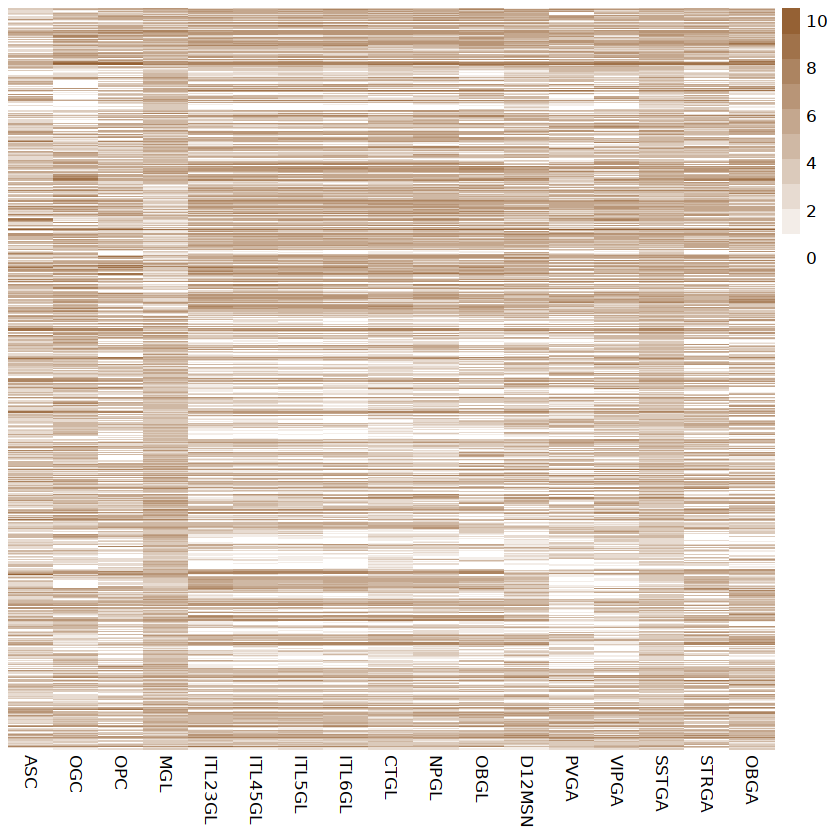

In [100]:
### compare with histone modification
korder <- intersect(corder, colnames(k27ac))
rmat <- comp[idx, korder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]
t1 <- smat %>%
pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, show_rownames = F,
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(10))

### H3K27ac
htp <- log2(k27ac[binall[idx, 'bin'], korder] + 1)
t1 <- htp[permutation_vector, ] %>%
pheatmap(scale = "none", cluster_cols = F, cluster_rows = F, show_rownames = F,
         color = colorRampPalette(c("white", "#2EA7E0"))(10))

### H3K27me3
htp <- log2(k27me3[binall[idx, 'bin'], korder] + 1) 
t2 <- htp[permutation_vector, ] %>%
pheatmap(scale = "none", cluster_cols = F, cluster_rows = F, show_rownames = F,
         color = colorRampPalette(c("white", "#956134"))(10))

Using bin as id variables

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


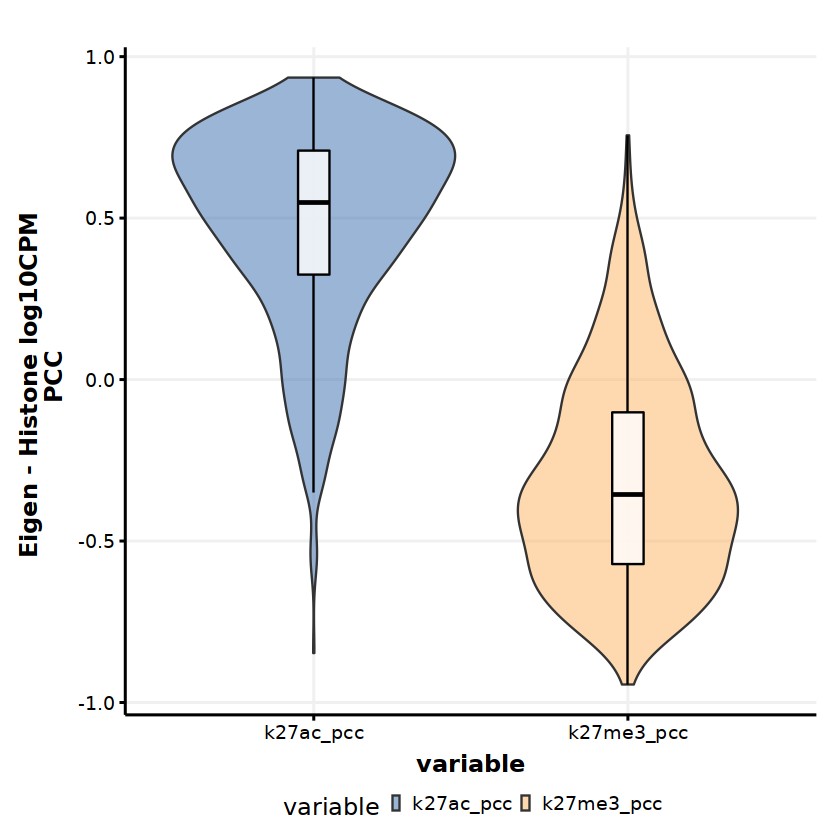

In [101]:
### summarize correlation
### for each bin, calulate cor
comp_htp <- smat
k27ac_htp <- log2(k27ac[binall[idx, 'bin'], korder] + 1)[permutation_vector, ]
k27me3_htp <- log2(k27me3[binall[idx, 'bin'], korder] + 1) [permutation_vector, ]

k27ac_pcc <- k27ac_scc <- k27me3_pcc <- k27me3_scc <- list()
for (i in 1:nrow(comp_htp)){
    k27ac_pcc[[i]] <- cor(unlist(comp_htp[i,]), unlist(k27ac_htp[i,]))
    k27ac_scc[[i]] <- cor(unlist(comp_htp[i,]), unlist(k27ac_htp[i,]), method = "spearman")
    k27me3_pcc[[i]] <- cor(unlist(comp_htp[i,]), unlist(k27me3_htp[i,]))
    k27me3_scc[[i]] <- cor(unlist(comp_htp[i,]), unlist(k27me3_htp[i,]), method = "spearman")
}
cor_df <- data.frame(bin = rownames(comp_htp),
                     k27ac_pcc = unlist(k27ac_pcc),
                     k27me3_pcc = unlist(k27me3_pcc), 
                     k27ac_scc = unlist(k27ac_scc),
                     k27me3_scc = unlist(k27me3_scc))

t1 <- cor_df %>%
reshape2::melt() %>%
dplyr::filter(variable %in% c("k27ac_pcc", "k27me3_pcc")) %>%
ggplot(aes(x = variable, y = value)) + 
geom_violin(alpha = 0.5, aes(fill = variable)) + 
geom_boxplot(width = 0.1, color = "black", alpha = 0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + 
ylab("Eigen - Histone log10CPM \n PCC") + 
scale_fill_Publication()

t1

## Differentail domains  (Fig.2C-E)

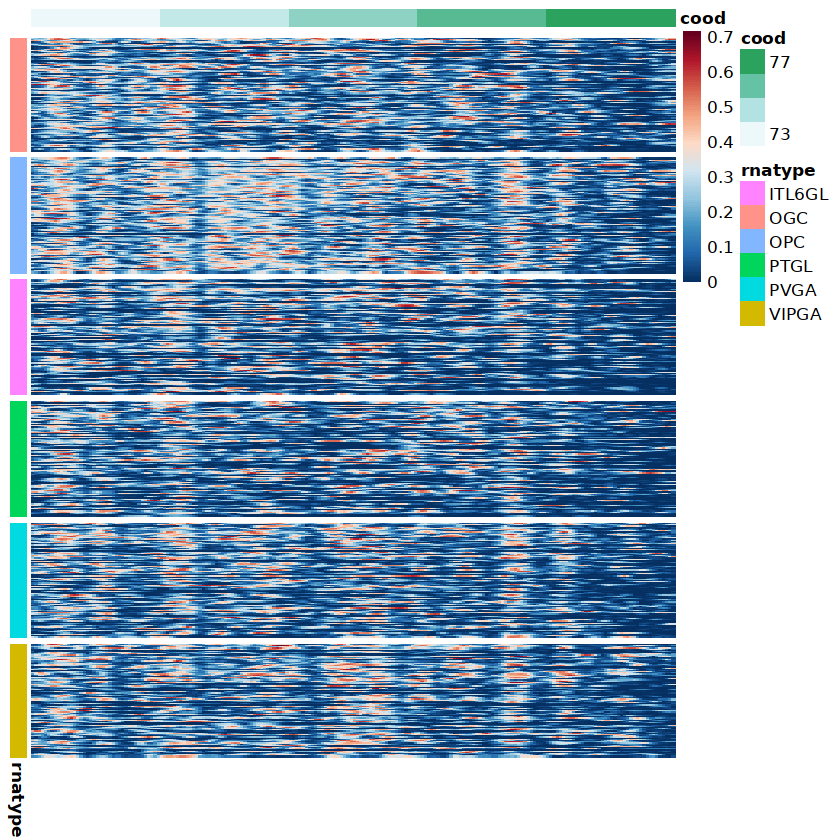

In [107]:
### Plot single cell examples
cluster <- read.csv('match_droplethic_DPT_RNA_AllCooL_integration_hi_annotation.csv', row.names = 1) %>% tibble::rownames_to_column("X")
tmp_df <- read.csv("plot/mFC_240101_DPT_rna_annotation_bulk_raw_chr5_73000000_78000000_ins.csv", row.names = 1)

### row annotation
tmp_meta <- cluster[match(rownames(tmp_df), cluster$X), c("X", "rnatype")] 
rownames(tmp_meta) <- tmp_meta$X
tmp_meta$X <- NULL

### gap
gap_list <- list()
for (f in unique(tmp_meta$rnatype)){
    gap_list[[f]] <- which(tmp_meta$rnatype == f)[1]
}

### col annotation
col_anno <- gsub("X", "", colnames(tmp_df)) %>% as.numeric %>% as.data.frame %>% setNames("cood") %>% mutate(cood = cood %/% 1000000)
rownames(col_anno) <- colnames(tmp_df)

t1 <- tmp_df %>%
pheatmap(cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
         annotation_row = tmp_meta, annotation_col = col_anno, gaps_row = unlist(gap_list)-1,
         color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(100))

In [283]:
### read boundary probability
probs = read.csv("mFC_240101_DPT_rna_annotation_hicluster_25kb_boundary_probs_filt_hicluster_v2.csv", row.names = 1)


### check DE genes?
marker <- read.table("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/DEgenes/FC_FC_DropletPT_Anno_DEgenes.xls", 
                     sep = "\t", header = T)
fmarker <- marker %>% group_by(cluster) %>% dplyr::filter(p_val_adj < 0.05 & (avg_log2FC) > 0.5 & (`pct.1` - `pct.2`) > 0.3) # %>% slice_max(order_by = abs(avg_log2FC), n = 50)
dim(fmarker)

### check HK genes?
### https://housekeeping.unicamp.br/?download
hk <- read.table("/projects/ps-renlab2/y2xie/projects/genome_ref/Housekeeping_Genes_Mouse.txt")
dim(hk)

### check constantly expressed genes (not DE, not HK)
library(Seurat)
mmg <- readRDS("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/seurat_object/FC_RNA_Seurat_merged_rmScrublet_221229.rds")
hvf <- HVFInfo(mmg) 
otgenes <- hvf %>% dplyr::filter(mean > 0.1 & variance.standardized < 0.94)
otgenes <- otgenes[!(rownames(otgenes) %in% c(fmarker$gene, hk$V1)),]
dim(otgenes)

[1] 1954    7

[1] 2928    1

[1] 2197    3

In [ ]:
### extend to 50kb windows left / right
qryr <- GRanges(seqnames = qry$chr, ranges = IRanges(start = as.integer(qry$start - 37500), end = as.integer(qry$end + 37500)),
               bin = qry$bin) 

fgenes <- genes[genes$gene %in% unique(fmarker$gene),]
hkgenes <- genes[genes$gene %in% unique(hk$V1),]
otgenes <- genes[genes$gene %in% unique(rownames(otgenes)),]

### cover TSS region
degener <- GRanges(seqnames = fgenes$chr, ranges = IRanges(start = (fgenes$start - 10000), end = fgenes$end), 
                 ensembl = fgenes$ensembl, gene = fgenes$gene, length = fgenes$end - fgenes$start) 
hkgener <- GRanges(seqnames = hkgenes$chr, ranges = IRanges(start = (hkgenes$start - 10000), end = hkgenes$end), 
                 ensembl = hkgenes$ensembl, gene = hkgenes$gene, length = hkgenes$end - hkgenes$start) 
otgener <- GRanges(seqnames = otgenes$chr, ranges = IRanges(start = (otgenes$start - 10000), end = otgenes$end), 
                 ensembl = otgenes$ensembl, gene = otgenes$gene, length = otgenes$end - otgenes$start) 


ovlp <- findOverlaps(qryr, degener)
t1 <- qryr[queryHits(ovlp)] %>% as.data.frame
t2 <- degener[subjectHits(ovlp)] %>% as.data.frame
qry_degenes <- bind_cols(t1, t2[,c("ensembl", "gene", "length")])

ovlp <- findOverlaps(qryr, hkgener)
t1 <- qryr[queryHits(ovlp)] %>% as.data.frame
t2 <- hkgener[subjectHits(ovlp)] %>% as.data.frame
qry_hkgenes <- bind_cols(t1, t2[,c("ensembl", "gene", "length")])

ovlp <- findOverlaps(qryr, otgener)
t1 <- qryr[queryHits(ovlp)] %>% as.data.frame
t2 <- otgener[subjectHits(ovlp)] %>% as.data.frame
qry_otgenes <- bind_cols(t1, t2[,c("ensembl", "gene", "length")])

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


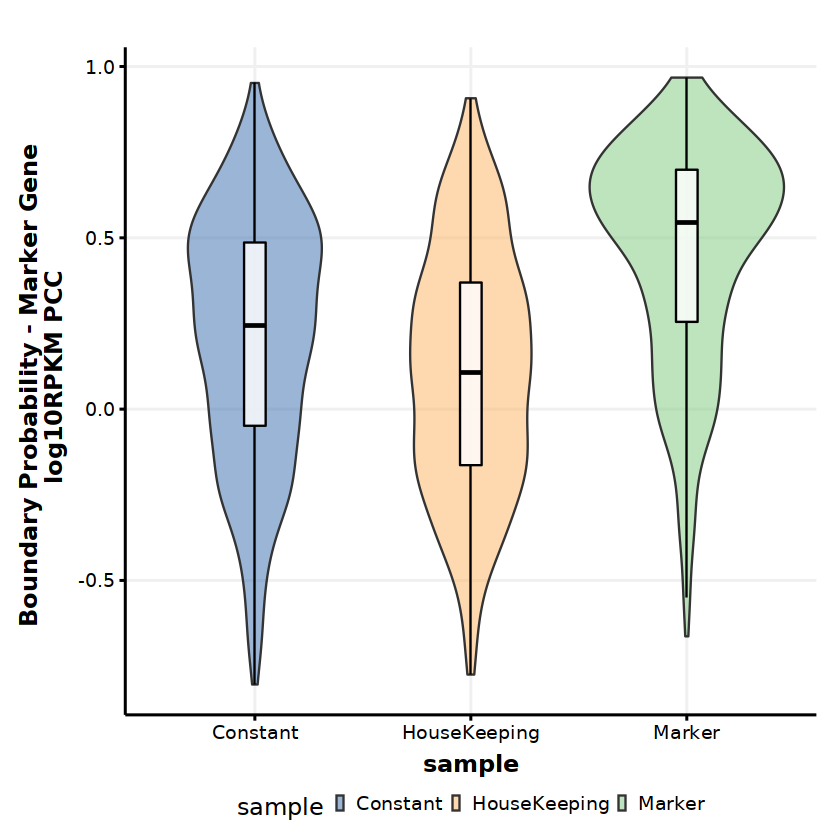

In [285]:
### check cor between gene expression and boundary probs
smat <- probs[rownames(selb), korder]
rownames(smat) <- selb[rownames(smat), "bin"] ### coarce rownames

goodb <- intersect(rownames(smat), qry_degenes$bin)
goodg <- qry_degenes[match(goodb, qry_degenes$bin), "gene"]
comp_htp <- smat[goodb,]
rna_htp <- log10(rna[goodg, korder] + 1)

goodb <- intersect(rownames(smat), qry_hkgenes$bin)
goodg <- qry_hkgenes[match(goodb, qry_hkgenes$bin), "gene"]
comp_htp2 <- smat[goodb,]
rna_htp2 <- log10(rna[goodg, korder] + 1)

goodb <- intersect(rownames(smat), qry_otgenes$bin)
goodg <- qry_otgenes[match(goodb, qry_otgenes$bin), "gene"]
comp_htp3 <- smat[goodb,]
rna_htp3 <- log10(rna[goodg, korder] + 1)

rna_pcc <- hk_pcc <- ot_pcc <- list()
for (i in 1:nrow(comp_htp)){
    rna_pcc[[i]] <- cor(unlist(comp_htp[i,]), unlist(rna_htp[i,]))
}
for (i in 1:nrow(comp_htp2)){
    hk_pcc[[i]] <- cor(unlist(comp_htp2[i,]), unlist(rna_htp2[i,]))
}
for (i in 1:nrow(comp_htp3)){
    ot_pcc[[i]] <- cor(unlist(comp_htp3[i,]), unlist(rna_htp3[i,]))
}

tmp1 <- as.data.frame(unlist(rna_pcc)) %>% setNames("PCC") %>% mutate(sample = "Marker")
tmp2 <- as.data.frame(unlist(hk_pcc)) %>% setNames("PCC") %>% mutate(sample = "HouseKeeping")
tmp3 <- as.data.frame(unlist(ot_pcc)) %>% setNames("PCC") %>% mutate(sample = "Constant")

t1 <- do.call(rbind, list(tmp1, tmp2, tmp3)) %>%
ggplot(aes(x = sample, y = PCC)) +  
geom_violin(alpha = 0.5, aes(fill = sample)) + 
geom_boxplot(width = 0.1, color = "black", alpha = 0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + 
ylab("Boundary Probability - Marker Gene \n log10RPKM PCC") + 
scale_fill_Publication()

t1

In [286]:
table(t1$data$sample)


    Constant HouseKeeping       Marker 
         521          512          448 

## Loops anchors analysis (Fig.2F-G)

In [126]:
k27ac <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27ac_10kb_CPM_by_class.csv", row.names = 1)
k27me3 <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27me3_10kb_CPM_by_class.csv", row.names = 1)

ck27ac <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27ac_10kb_CPM_by_cluster.csv", row.names = 1)
ck27me3 <- read.csv("../../39.Paired_HiC_NovaSeq_230125/05.R/Paired-Tag/FC_H3K27me3_10kb_CPM_by_cluster.csv", row.names = 1)
k27ac <- cbind(k27ac, ck27ac)
k27me3 <- cbind(k27me3, ck27me3)

colnames(k27ac)
korder <- intersect(corder, colnames(k27ac))

[1] "NonN"      "GABA"      "Glutamate" "OPC"       "OGC"       "ASC"      
 [7] "SSTGA"     "ITL23GL"   "VIPGA"     "ITL45GL"   "D12MSN"    "STRGA"    
[13] "CTGL"      "NPGL"      "ITL5GL"    "OBGA"      "OBGL"      "ITL6GL"   
[19] "PTGL"      "MGL"       "PVGA"      "CLAGL"     "VLMC"

In [130]:
### load All loops
loops_dir = "../hicluster/imputed_matrix/10kb_resolution/loop/DPT/"
loops_list <- list()
for (file in list.files(loops_dir, pattern = "*.loopsummit.bedpe")){
    fname = gsub("^imputematrices_([^.]+).loopsummit.bedpe$", "\\1", file)
    if (fname %in% c("VLMC", "CLAGL")){
        next
    }else{
        tmp = read.table(paste0(loops_dir, "/imputematrices_", fname, ".loop.bedpe"), sep = "\t")
        tmp$sample <- fname
        loops_list[[fname]] <- tmp 
    } 
}

loops_list <- do.call(rbind, loops_list)

### get loops anchors
t1 <- loops_list[,c(1:3,8)] %>% setNames(c("chrom", "start", "end", "sample"))
t2 <- loops_list[,c(4:6,8)] %>% setNames(c("chrom", "start", "end", "sample"))
loops_anchors <- rbind(t1, t2)
head(loops_anchors)

chrom start    end      sample
ASC.1 chr1   4930000  4940000 ASC   
ASC.2 chr1   5000000  5010000 ASC   
ASC.3 chr1   5010000  5020000 ASC   
ASC.4 chr1  20810000 20820000 ASC   
ASC.5 chr1  20820000 20830000 ASC   
ASC.6 chr1  20820000 20830000 ASC

In [131]:
### match histone modification!
loops_anchors <- loops_anchors %>% mutate(bin = paste0(chrom, "-", (start+1), "-", end))
loops_anchors_K27ac <- merge(loops_anchors, k27ac, by.x = "bin", by.y = 0, all.x = T) %>% filter(sample %in% korder)
loops_anchors_K27me3 <- merge(loops_anchors, k27me3, by.x = "bin", by.y = 0, all.x = T) %>% filter(sample %in% korder)

Using sample as id variables

Using sample as id variables



[[1]]

[[2]]


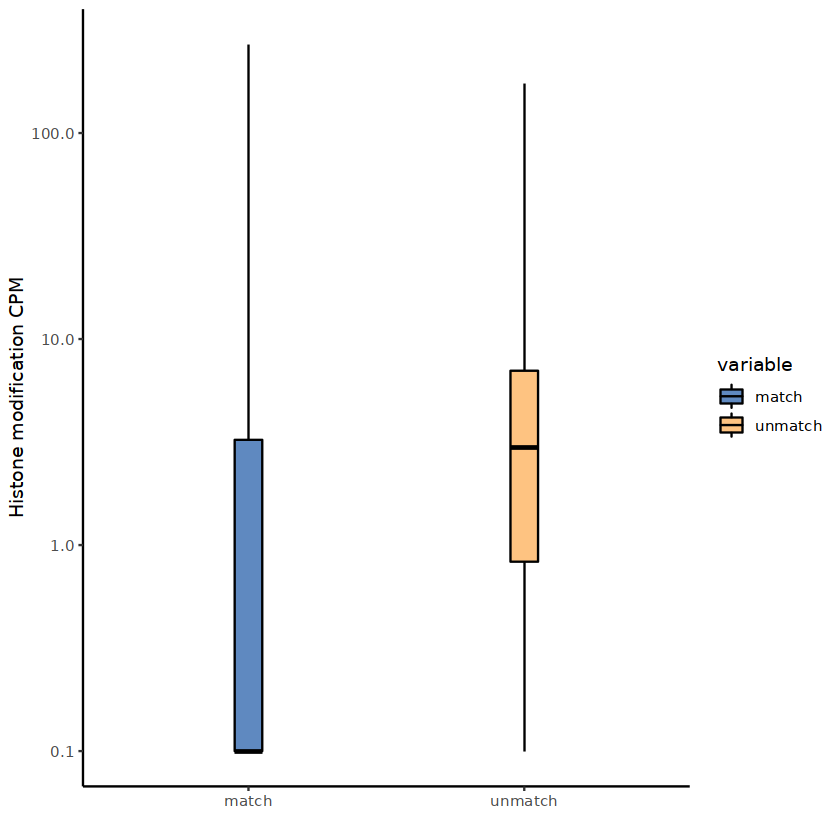

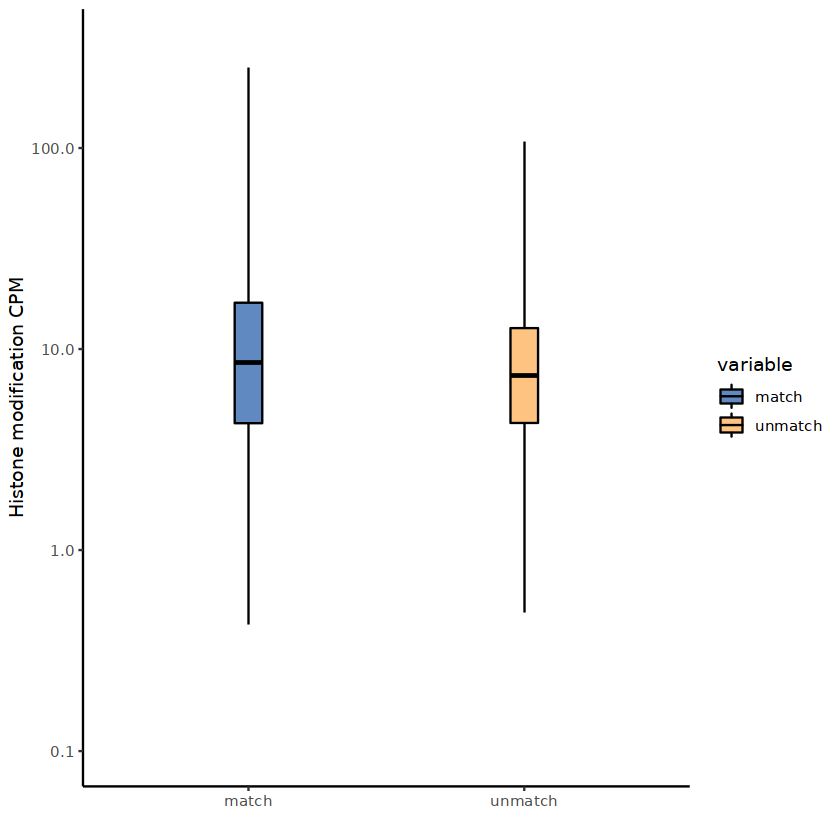

In [150]:
i = 1
tlist <- list()
names = c("K27me3", "K27ac")
for (tmp in list(loops_anchors_K27me3, loops_anchors_K27ac)){
    fname = names[i]
    ctc <- unique(tmp$sample)
    mat_list <- lapply(1:nrow(tmp), function(x) tmp[x,tmp$sample[x]])
    tmp$match <- unlist(mat_list)

    unmat_list <- lapply(1:nrow(tmp), function(x) mean(unlist(tmp[x, setdiff(ctc, tmp$sample[x])])))
    tmp$unmatch <- unlist(unmat_list)

    t1 <- tmp[,c("sample", "match", "unmatch")] %>%
    reshape2::melt() %>%
    ggplot(aes(x = variable, y = value + 0.1, fill = variable, color = variable)) + 
    # geom_violin(alpha = 0.5) + 
    geom_boxplot(width = 0.1, color = "black", alpha = 0.8, coef = 2, outlier.shape = NA, position=position_dodge(0.9)) + 
    theme_classic() + 
    scale_y_log10() + ylab("Histone modification CPM") + xlab("") +
    scale_fill_Publication() + 
    scale_colour_Publication()

    tlist[[i]] <- t1
    i = i + 1
}
                         
tlist

In [151]:
tmp <- tlist[[1]]$data
wilcox.test(tmp[tmp$variable == "match",  "value"], tmp[tmp$variable == "unmatch",  "value"])

tmp <- tlist[[2]]$data
wilcox.test(tmp[tmp$variable == "match",  "value"], tmp[tmp$variable == "unmatch",  "value"])


	Wilcoxon rank sum test with continuity correction

data:  tmp[tmp$variable == "match", "value"] and tmp[tmp$variable == "unmatch", "value"]
W = 1.7347e+11, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  tmp[tmp$variable == "match", "value"] and tmp[tmp$variable == "unmatch", "value"]
W = 3.4521e+11, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [135]:
### Run GREAT analysis of anchors
for (f in unique(loops_anchors$sample)){
    tmp <- loops_anchors[loops_anchors$sample == f, 1:3]
    write.table(tmp, paste0(loops_dir, "anchors/", f, "_loops_anchors.bed"), 
                row.names = F, col.names = F, sep = "\t", quote = F)
}

### Rscript scripts/run_rGREAT_yel.R -s mm10 -i ${s}_loops_anchors.bed -o ${s}

In [159]:
great_list <- list()
for (f in unique(loops_anchors$sample)){
    tmp <- read.csv(paste0(loops_dir, "anchors/GREAT/", f, "_loops_anchors.rGREAT.bp.tsv"), sep = "\t")
    tmp <- tmp %>% dplyr::filter((Hyper_Total_Genes >= 5) & (Hyper_Total_Genes < 1000) & Hyper_Adjp_BH < 0.01)
    tmp$sample <- f
    great_list[[f]] <- tmp
}

great_list <- do.call(rbind, great_list)


great_list %>% 
dplyr::filter(sample == "VIPGA") %>%
dplyr::filter((Hyper_Total_Genes >= 5) & (Hyper_Total_Genes < 500) & Hyper_Adjp_BH < 0.01) %>%
slice_max(order_by = (Binom_Fold_Enrichment*-log10(Binom_Adjp_BH)), n = 5)

ID         name                                     
VIPGA.1   GO:0034762 regulation of transmembrane transport    
VIPGA.2   GO:0034765 regulation of ion transmembrane transport
VIPGA.57  GO:0090036 regulation of protein kinase C signaling 
VIPGA.4   GO:0006836 neurotransmitter transport               
VIPGA.122 GO:1905048 regulation of metallopeptidase activity  
          Binom_Genome_Fraction Binom_Expected Binom_Observed_Region_Hits
VIPGA.1   0.049939640           2567.09700     4882                      
VIPGA.2   0.048798290           2508.42700     4763                      
VIPGA.57  0.002039347            104.83060      521                      
VIPGA.4   0.011889600            611.17310     1768                      
VIPGA.122 0.001088151             55.93532      336                      
          Binom_Fold_Enrichment Binom_Region_Set_Coverage Binom_Raw_PValue
VIPGA.1   1.901759              0.094973150                0.000000e+00   
VIPGA.2   1.898799              0.092658160                0.000000e+00   
VIPGA.57  4.969923              0.010135400               3.530358e-185   
VIPGA.4   2.892797              0.034394210               1.112537e-308   
VIPGA.122 6.006938              0.006536456               1.224993e-142   
          Binom_Adjp_BH Hyper_Total_Genes Hyper_Expected
VIPGA.1    0.000000e+00 435               134.434200    
VIPGA.2    0.000000e+00 421               130.107600    
VIPGA.57  2.287742e-183  17                 5.253751    
VIPGA.4   1.112537e-308 125                38.630520    
VIPGA.122 5.206220e-141  13                 4.017574    
          Hyper_Observed_Gene_Hits Hyper_Fold_Enrichment
VIPGA.1   227                      1.688558             
VIPGA.2   216                      1.660164             
VIPGA.57   13                      2.474423             
VIPGA.4    60                      1.553176             
VIPGA.122  11                      2.737971             
          Hyper_Gene_Set_Coverage Hyper_Term_Gene_Coverage Hyper_Raw_PValue
VIPGA.1   0.034331520             0.5218391                1.000402e-20    
VIPGA.2   0.032667880             0.5130641                1.175982e-18    
VIPGA.57  0.001966122             0.7647059                1.441647e-04    
VIPGA.4   0.009074410             0.4800000                4.498523e-05    
VIPGA.122 0.001663642             0.8461538                9.803238e-05    
          Hyper_Adjp_BH sample
VIPGA.1   1.393113e-18  VIPGA 
VIPGA.2   1.399419e-16  VIPGA 
VIPGA.57  2.292972e-03  VIPGA 
VIPGA.4   8.212785e-04  VIPGA 
VIPGA.122 1.634706e-03  VIPGA

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


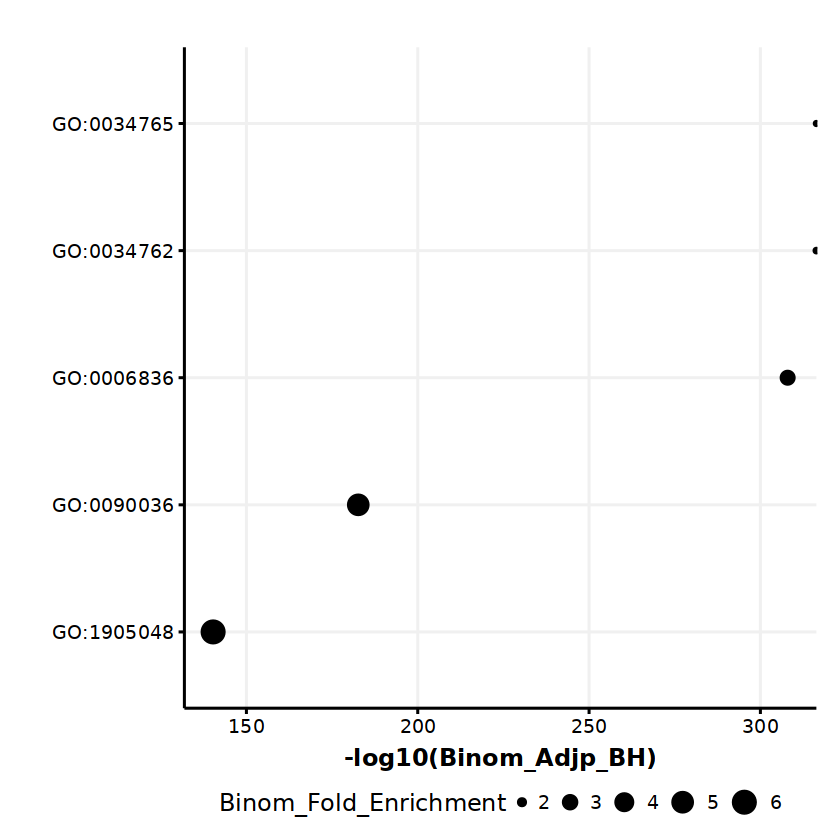

In [167]:
### VIPGA

t1 <- great_list %>% 
dplyr::filter(sample == "VIPGA") %>%
dplyr::filter((Hyper_Total_Genes >= 5) & (Hyper_Total_Genes < 500) & Hyper_Adjp_BH < 0.01) %>%
slice_max(order_by = (Binom_Fold_Enrichment*-log10(Binom_Adjp_BH)), n = 5) %>%
dplyr::select(c(ID, name, Binom_Fold_Enrichment, Binom_Adjp_BH)) %>% 
ggplot(aes(x = -log10(Binom_Adjp_BH), y = fct_reorder(ID, -log10(Binom_Adjp_BH)))) + 
geom_point(aes(size = Binom_Fold_Enrichment)) + 
theme_Publication() + ylab("")

t1

ID         name                                          
OGC.2  GO:0034248 regulation of cellular amide metabolic process
OGC.8  GO:0042552 myelination                                   
OGC.10 GO:0008366 axon ensheathment                             
OGC.5  GO:0006417 regulation of translation                     
OGC.4  GO:0009894 regulation of catabolic process               
       Binom_Genome_Fraction Binom_Expected Binom_Observed_Region_Hits
OGC.2  0.025016630           1189.5910      2749                      
OGC.8  0.008503768            404.3712      1183                      
OGC.10 0.009275473            441.0673      1234                      
OGC.5  0.022283750           1059.6370      2269                      
OGC.4  0.042859160           2038.0390      3726                      
       Binom_Fold_Enrichment Binom_Region_Set_Coverage Binom_Raw_PValue
OGC.2  2.310879              0.05781040                 0.000000e+00   
OGC.8  2.925530              0.02487803                1.185729e-218   
OGC.10 2.797759              0.02595054                2.170753e-212   
OGC.5  2.141299              0.04771618                1.653633e-234   
OGC.4  1.828228              0.07835633                1.379585e-259   
       Binom_Adjp_BH Hyper_Total_Genes Hyper_Expected Hyper_Observed_Gene_Hits
OGC.2   0.000000e+00 363               109.24780      146                     
OGC.8  1.261886e-216  93                27.98911       54                     
OGC.10 2.202725e-210  96                28.89198       56                     
OGC.5  2.022996e-232 331                99.61715      132                     
OGC.4  1.941803e-257 479               144.15900      195                     
       Hyper_Fold_Enrichment Hyper_Gene_Set_Coverage Hyper_Term_Gene_Coverage
OGC.2  1.336411              0.022674330             0.4022039               
OGC.8  1.929322              0.008386395             0.5806452               
OGC.10 1.938254              0.008697003             0.5833333               
OGC.5  1.325073              0.020500080             0.3987915               
OGC.4  1.352673              0.030284210             0.4070981               
       Hyper_Raw_PValue Hyper_Adjp_BH sample
OGC.2  2.214758e-05     7.772435e-04  OGC   
OGC.8  1.939468e-08     1.251452e-06  OGC   
OGC.10 8.454992e-09     5.734500e-07  OGC   
OGC.5  8.430144e-05     2.485463e-03  OGC   
OGC.4  3.835306e-07     1.894496e-05  OGC

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


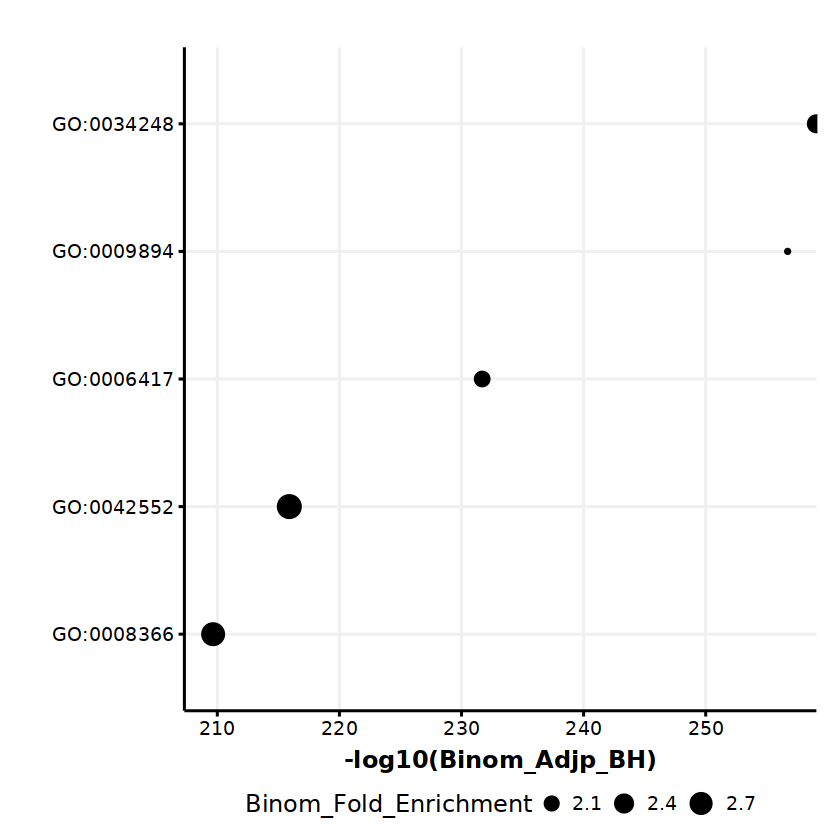

In [166]:
### OGC

great_list %>% 
dplyr::filter(sample == "OGC") %>%
dplyr::filter((Hyper_Total_Genes >= 5) & (Hyper_Total_Genes < 500) & Hyper_Adjp_BH < 0.01) %>%
slice_max(order_by = (Binom_Fold_Enrichment*-log10(Binom_Adjp_BH)), n = 5)

t2 <- great_list %>% 
dplyr::filter(sample == "OGC") %>%
dplyr::filter((Hyper_Total_Genes >= 5) & (Hyper_Total_Genes < 500) & Hyper_Adjp_BH < 0.01) %>%
slice_max(order_by = (Binom_Fold_Enrichment*-log10(Binom_Adjp_BH)), n = 5) %>%
dplyr::select(c(ID, name, Binom_Fold_Enrichment, Binom_Adjp_BH)) %>% 
ggplot(aes(x = -log10(Binom_Adjp_BH), y = fct_reorder(ID, -log10(Binom_Adjp_BH)))) + 
geom_point(aes(size = Binom_Fold_Enrichment)) + 
theme_Publication() + ylab("")

t2